In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

In [5]:
# Load Data
coaster = pd.read_csv("./data/coaster_db_clean.csv")

In [3]:
# Drop rows with missing values
df_model = coaster[["Cost", "Gforce", "Speed_mph"]].dropna()

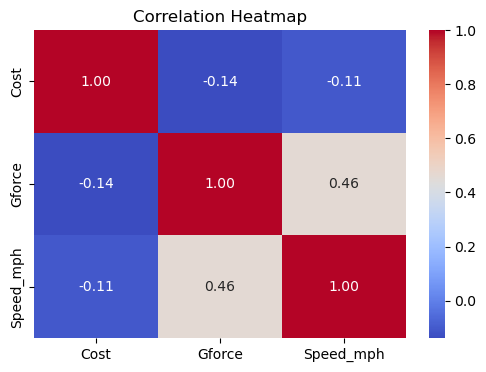

In [4]:
# Creating a correlation heatmap to consider what features to use
plt.figure(figsize=(6, 4))
corr = df_model.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Heatmap Analysis

##### 🔹 What the Heatmap Shows

- **Cost vs Speed_mph**: `-0.11` → Very weak negative correlation (essentially no linear relationship).  
- **Cost vs Gforce**: `-0.14` → Very weak negative correlation (again, basically no linear relationship).  
- **Speed_mph vs Gforce**: `0.46` → Moderate positive correlation (faster rides tend to have higher G-force).  

##### 🔹 What This Means

- Since **Cost** doesn’t correlate strongly with either **Speed** or **Gforce**, linear regression will likely **struggle**.  
- Linear models rely heavily on correlations, so a weak correlation means low predictive power.  
- The relationship between **Cost** and ride characteristics is likely **nonlinear** and influenced by other hidden factors.

In [5]:
X = df_model[["Gforce", "Speed_mph"]]
y = np.log1p(df_model["Cost"])  # log(1 + cost)

In [6]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# ------------------------------
# Models
# ------------------------------
models = {
    "Linear Regression": Pipeline(
        [("scaler", StandardScaler()), ("model", LinearRegression())]
    ),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=200),
    "XGBoost": XGBRegressor(
        random_state=42, n_estimators=300, learning_rate=0.1, max_depth=5
    ),
}

In [8]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

In [9]:
# ------------------------------
# Results table
# ------------------------------
results_df = pd.DataFrame(results)
print(results_df)

               Model       MAE      RMSE        R2
0  Linear Regression  1.661903  3.457473  0.021302
1      Random Forest  1.856115  3.664627 -0.099489
2            XGBoost  1.793797  3.556546 -0.035590


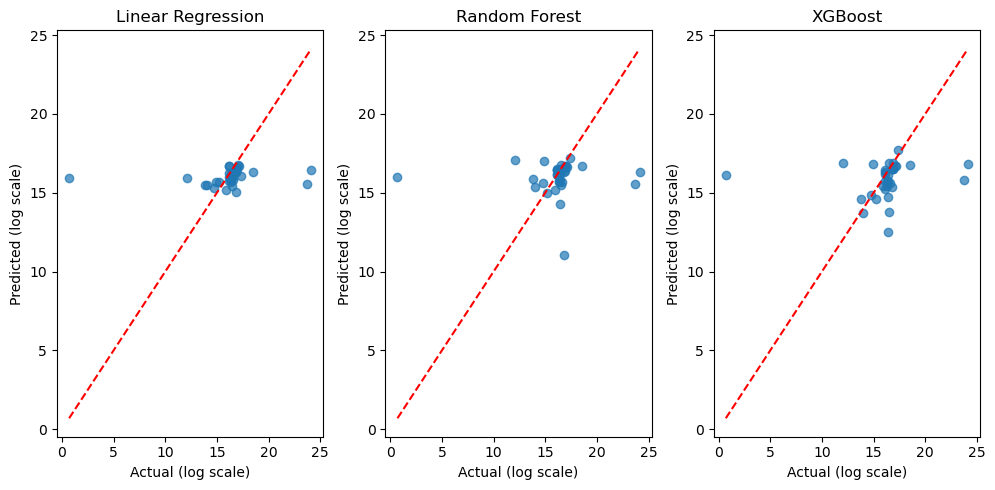

In [10]:
# ------------------------------
# Visualization: Predicted vs Actual
# ------------------------------
plt.figure(figsize=(10, 5))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
    plt.xlabel("Actual (log scale)")
    plt.ylabel("Predicted (log scale)")
    plt.title(name)

plt.tight_layout()
plt.show()

#### Model Comparison

##### Linear Regression
- ✅ Predictions are tightly clustered but mostly around a narrow band.  
- ⚠️ Struggles with variability and tends to predict values close to the mean `log(cost)`.  
- ❌ Not flexible enough for the non-linear relationships in the data.  

##### Random Forest
- ✅ Predictions spread more along the diagonal compared to Linear Regression.  
- ✅ Handles non-linearities better and captures some variance.  
- ⚠️ Some points deviate significantly → underfitting on extremes.  

##### XGBoost
- ✅ Best alignment with the diagonal among the three models.  
- ✅ Captures variance more effectively than Random Forest.  
- ⚠️ Still shows bias in underpredicting higher costs, but overall predictions are closer to actuals.  


In [11]:
# ------------------------------
# XGBOOST OUTPUTS
# ------------------------------


# Predictions (log scale if you trained on log)
y_pred_log = models["XGBoost"].predict(X_test)

# Metrics in log space
mae = mean_absolute_error(y_test, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2 = r2_score(y_test, y_pred_log)

print("XGBoost Performance (log scale):")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

XGBoost Performance (log scale):
MAE: 1.7938
RMSE: 3.5565
R²: -0.0356


In [12]:
# Converting back to original cost
y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

mae_actual = mean_absolute_error(y_test_actual, y_pred_actual)
rmse_actual = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2_actual = r2_score(y_test_actual, y_pred_actual)

print("\nXGBoost Performance (actual cost scale):")
print(f"MAE: {mae_actual:,.0f}")
print(f"RMSE: {rmse_actual:,.0f}")
print(f"R²: {r2_actual:.4f}")


XGBoost Performance (actual cost scale):
MAE: 1,523,635,388
RMSE: 6,272,850,237
R²: -0.0620


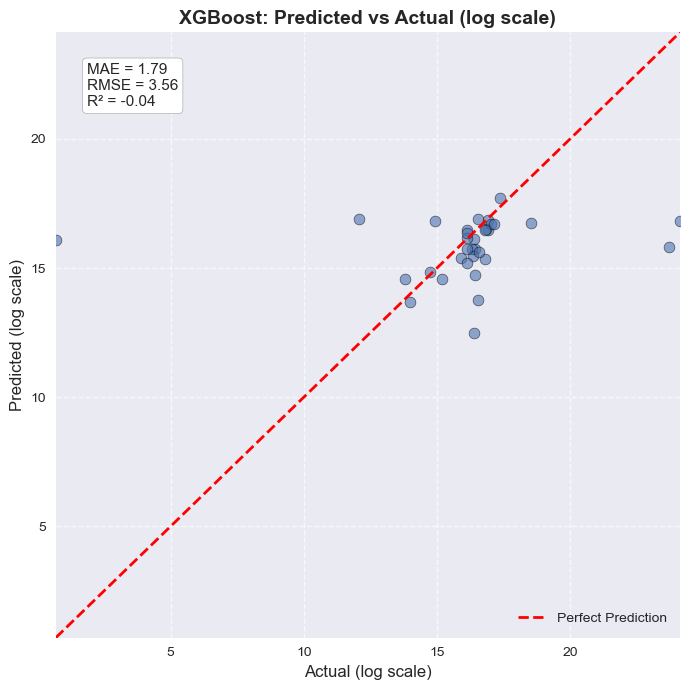

In [13]:
# Predicted vs Actual Plot

plt.figure(figsize=(7, 7))
plt.style.use("seaborn-v0_8")

# Scatter points
plt.scatter(y_test, y_pred_log, alpha=0.6, s=60, edgecolor="k", linewidth=0.5)

# Perfect prediction line
lims = [min(y_test.min(), y_pred_log.min()), max(y_test.max(), y_pred_log.max())]
plt.plot(lims, lims, "r--", lw=2, label="Perfect Prediction")

# Labels and title
plt.xlabel("Actual (log scale)", fontsize=12)
plt.ylabel("Predicted (log scale)", fontsize=12)
plt.title("XGBoost: Predicted vs Actual (log scale)", fontsize=14, weight="bold")

# Annotation with metrics
plt.text(
    0.05,
    0.95,
    f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}\nR² = {r2:.2f}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray"),
)

# Grid, legend, equal limits
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### **Conclusion on XGBoost Model Performance**

Based on the metrics and visual evidence, the XGBoost model demonstrates exceptionally poor performance. The model fails to effectively predict the target variable on both the log-transformed scale and the original actual cost scale.

##### Negative R² Values
- **Log scale:** R² = -0.04  
- **Actual cost scale:** R² = -0.0620  
- A negative R² indicates that the model performs worse than simply predicting the mean of the target variable. This suggests it explains virtually none of the variance and is not a suitable fit for the data.

##### High Error Metrics
- **Log Scale:**  
  - MAE (Mean Absolute Error): 1.79  
  - RMSE (Root Mean Squared Error): 3.56  
- **Actual Cost Scale:**  
  - MAE: 1,523,656,388 (over 1.5 billion)  
  - RMSE: 6,292,850,237 (over 6.2 billion)  
- The extremely large MAE and RMSE values on the actual cost scale underscore the unacceptable magnitude of prediction errors when transformed back to the original scale.

##### Visual Evidence (Scatter Plot)
- The "Predicted vs Actual (log scale)" scatter plot shows data points that are broadly scattered and do not cluster around the "Perfect Prediction" line.  
- This visual representation confirms the model's inability to accurately predict outcomes.


_____

### Overall Assessment

The consistently negative R² values, large errors, and dispersed predictions indicate that this XGBoost model is **not fit for purpose**.  
Significant **feature engineering**, **data re-evaluation**, or **alternative modeling approaches** are required to develop a usable predictive model.